<a href="https://colab.research.google.com/github/jumafernandez/clasificacion_correos/blob/main/notebooks/jaiio/01-features_selection_tf-idf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo 50 JAIIO

___Título:___ E-mail mining: un enfoque semi-supervisado para la identificación, el etiquetado y la clasificación de consultas académicas

___Autores:___ Nicolás Cavasin, Juan Manuel Fernandez, Marcelo Errecalde

## 0. Misceláneos:

### Descarga de librerias necesarias

In [ ]:
!pip install es-lemmatizer
!python -m spacy download es
!pip install requests
!pip install wget

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/es_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/es
You can now load the model via spacy.load('es')


In [ ]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/jcc/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import consolidar_df

### Descarga dataset de training ya discretizado y con 800 correos etiquetados:

In [ ]:
# Descargo los correos ya etiquetados
from os import path

if not (path.exists('correos-train-80.csv')):
    !wget https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/consolidado_jcc/correos-train-80.csv

## 1. Presentación del dataset:

### 1.1 Se levanta en un DataFrame para poder manipularlo

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargo correos en un dataframe
#correos = pd.read_csv('01-Correos_Seleccionados_y_Etiquetados.csv', sep='|')
correos = pd.read_csv('correos-train-80.csv')

# Muestro forma
print(f'Shape = {len(correos)} tuplas x {correos.shape[1]} columnas.\n')

# Muestro top 5
correos.head()

Shape = 800 tuplas x 24 columnas.



Consulta  ...  clase
0  quisiera saber porque no tengo el numero de le...  ...     12
1  quería cambiarme al prof. de educ. física. qui...  ...      1
2  hola. quiero saber en que condición estoy para...  ...     15
3  estimados, no puedo inscribirme a las cursadas...  ...     15
4  estoy tratando de realizar la prescripción on-...  ...     11

[5 rows x 24 columns]

### 1.2 Muestro 5 consultas

In [ ]:
# Muestro por completo las primeras 5 consultas
for idx, e in enumerate(correos['Consulta'][0:5]):
    print(f'{idx+1} - {e}\n')

1 - quisiera saber porque no tengo el numero de legajo? lo necesitaria para poder anotarme en los horarios de las materias. muchas gracias 

2 - quería cambiarme al prof. de educ. física. quiero ver la oferta de asignaturas y así ver los horarios, ya que me dijeron qué tenía abril/mayo para el cambio de carrera. pero no me deja entrar porque dice que el período de inscripción no está vigente. gracias 

3 - hola. quiero saber en que condición estoy para retomar la carrera. ya estuve libre y no se si me puedo reinscribir. en caso de no poder, &iquest;como hago para no perder lo cursado? gracias. 

4 - estimados, no puedo inscribirme a las cursadas de la licenciatura en historia, ya que, al realizar los pasos correspondientes me dice que estoy en condición de libre.  a la espera de una respuesta favorable, desde ya muchas gracias, alberto. 

5 - estoy tratando de realizar la prescripción on-line y luego de llenar con los datos no me llega ningún mail para continuar con la operación.  



### 1.3 Escalado de los datos

In [ ]:
# Escalado Min-Max
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Mantengo el tipo de dato DataFrame
correos[correos.columns.difference(['Consulta', 'clase'])] = pd.DataFrame(scaler.fit_transform(correos[correos.columns.difference(['Consulta', 'clase'])]), columns=correos.columns.difference(['Consulta', 'clase']))

correos.head()

Consulta  ...  clase
0  quisiera saber porque no tengo el numero de le...  ...     12
1  quería cambiarme al prof. de educ. física. qui...  ...      1
2  hola. quiero saber en que condición estoy para...  ...     15
3  estimados, no puedo inscribirme a las cursadas...  ...     15
4  estoy tratando de realizar la prescripción on-...  ...     11

[5 rows x 24 columns]

## 2. Análisis Exploratorio de Datos:


### 2.1 Transformación de las clases identificadas por el experto

In [ ]:
from sklearn.preprocessing import LabelEncoder

clases = ['Boleto Universitario', 'Cambio de Carrera', 'Cambio de Comisión',
          'Carga de Notas', 'Certificados Web', 'Consulta por Equivalencias',
          'Consulta por Legajo', 'Consulta sobre Título Universitario',
          'Cursadas', 'Datos Personales', 'Exámenes',
          'Ingreso a la Universidad', 'Inscripción a Cursadas',
          'Pedido de Certificados', 'Problemas con la Clave',
          'Reincorporación', 'Requisitos de Ingreso',
          'Simultaneidad de Carreras', 'Situación Académica', 
          'Vacunas Enfermería']

# Instancio el transformador
le = LabelEncoder()

# Discretizo
clases_disc = le.fit_transform(clases)

# Muestro clases originales
print(f'Clases originales:\n{clases}\n')

# Muestro clases discretizadas
print(f'Clases discretizadas:\n{clases_disc}\n')

# Accedo a la clase original por su valor discretizado
print(f'Acceso a la original con discretizada:\n{clases[clases_disc[2]]}')

Clases originales:
['Boleto Universitario', 'Cambio de Carrera', 'Cambio de Comisión', 'Carga de Notas', 'Certificados Web', 'Consulta por Equivalencias', 'Consulta por Legajo', 'Consulta sobre Título Universitario', 'Cursadas', 'Datos Personales', 'Exámenes', 'Ingreso a la Universidad', 'Inscripción a Cursadas', 'Pedido de Certificados', 'Problemas con la Clave', 'Reincorporación', 'Requisitos de Ingreso', 'Simultaneidad de Carreras', 'Situación Académica', 'Vacunas Enfermería']

Clases discretizadas:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]

Acceso a la original con discretizada:
Cambio de Comisión


### 2.2 Creación de un dataframe con las clases originales sin discretizar

In [ ]:
# Creo un nuevo dataframe
correos_clase = correos.copy()

# Aplico una transformacion inversa para des-discretizar
correos_clase['clase'] = le.inverse_transform(correos['clase'])

# Muestro las primeras 5 clases originales
correos_clase['clase'].head()

0      Inscripción a Cursadas
1           Cambio de Carrera
2             Reincorporación
3             Reincorporación
4    Ingreso a la Universidad
Name: clase, dtype: object

### 2.3 Presentación de la distribución de *clase*


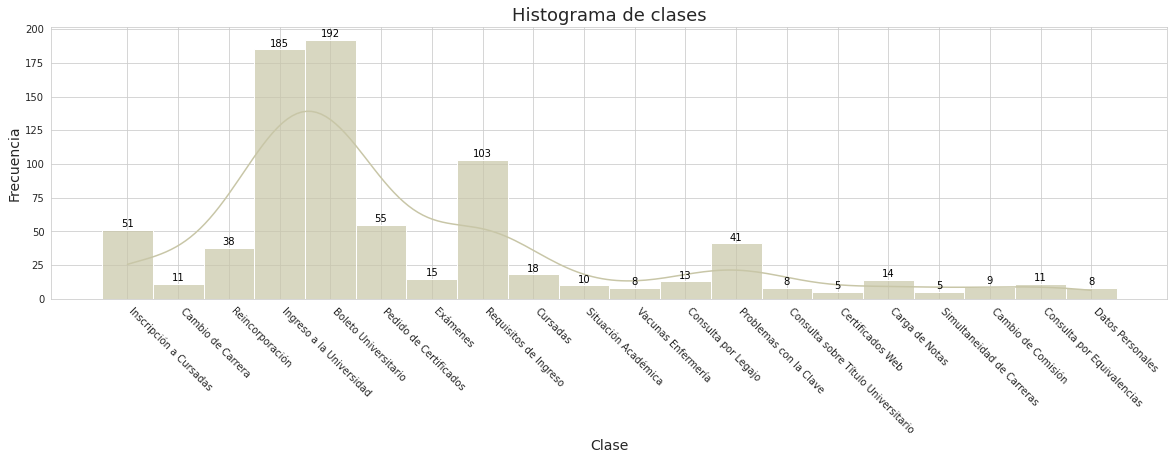

In [ ]:
from matplotlib import pyplot
import seaborn as sns

sns.set_style('whitegrid')
plt.figure(figsize=(20,5))
plt.tight_layout()

ax = sns.histplot(correos_clase['clase'], kde=True, stat='count', 
                  bins=correos['clase'].unique(), binwidth=0.1, 
                  color='#c8c6a7', alpha=0.7)

ax.set_xticklabels(correos_clase['clase'].unique(), 
                   rotation=-45, 
                   horizontalalignment='left', fontweight='light')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}\n',
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='center', color='black')

plt.title('Histograma de clases', fontsize = 18)
plt.xlabel('Clase', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.savefig('histograma.png', optimize=True, 
            transparent=True, bbox_inches = 'tight')

## 3. Pre-procesamiento:

### 3.1 Tokenización de *Consulta*

In [ ]:
import warnings 
warnings.filterwarnings(action='ignore')

import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
from string import punctuation

# Instancio la lista de stopwords en español propuesta por nltk
stop_words_es = set(stopwords.words('spanish'))

# Instancio, tokenizo y agrego puntuacion a la lista de stop_words
punkt = set(nltk.word_tokenize(punctuation))
punkt.union({'¡', '¿'})
stop_words = stop_words_es.union(punkt)

# Agrego palabras que consideramos irrelevantes
irrelevantes = {'hola', 'chau', 'gracias', 'saludos', 'adios', 'buenas', 'buen'}

# Uno los sets
stop_words = stop_words.union(irrelevantes)

# Muestro version final de stop_words
print(f'STOPWORDS: {stop_words}')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Instancio el transformador
consultas_rep = TfidfVectorizer(analyzer='word', decode_error='ignore', min_df=5,
                                strip_accents='unicode', stop_words=stop_words)

# Vectorizo y cuento las ocurrencias de Consulta
features = consultas_rep.fit_transform(correos['Consulta'])

# Muestro forma y ocurrenccias
print(f'\nShape = {features.shape[0]} tuplas x {features.shape[1]} columnas.\n')
print(f'Vocabulario <\'token\':ocurrencias>:\n{consultas_rep.vocabulary_}\n')

warnings.resetwarnings()

STOPWORDS: {'esas', 'tuviera', 'míos', 'suyos', 'hubiésemos', 'tendrá', 'sentidas', 'habré', 'tened', 'sin', 'tanto', 'estuviese', 'estada', 'habíamos', 'unos', 'hayáis', 'yo', ',', 'sentid', 'estabas', 'ya', 'el', 'sentida', 'tiene', 'mi', 'nuestro', 'entre', 'a', 'estados', 'tuviese', 'les', 'mía', 'gracias', 'algo', 'estuvieseis', 'saludos', 'estad', "''", 'le', 'quien', 'mío', 'fuera', 'tengas', 'otros', 'te', 'está', 'hubisteis', 'fueron', 'sintiendo', 'tenías', 'otras', 'eras', 'tenéis', 'soy', 'habríais', 'estuvierais', '^_`', 'habréis', 'cuando', 'estaríamos', 'un', 'tuviéramos', 'habremos', 'estas', 'vuestro', 'estuvieses', 'estará', 'suyo', 'esos', 'como', 'nuestras', 'he', 'sí', 'tuvierais', 'estaba', 'vuestros', 'habrán', 'buen', 'tuyos', 'eso', 'estuvimos', 'nada', 'habrías', 'tienes', '@', 'no', 'estés', 'estos', 'nuestros', 'habidos', 'haya', 'teníamos', 'esté', 'seas', 'estás', 'tuvimos', 'durante', 'habría', 'una', 'él', 'tengan', '!', 'fuese', 'sean', 'será', 'estaréi

In [ ]:
# Almaceno vocabulario en un dataframe
vocabulario = pd.DataFrame(features.toarray(), columns=consultas_rep.get_feature_names())

### 3.2 Consolidación de features de las consultas y escalado

In [ ]:
# Incorporo el TF-IDF a los atributos estáticos y los consolido en X_train
X_train, y_train = consolidar_df(correos_clase, vocabulario, 'Consulta', 'clase')

In [ ]:
# Escalado Min-Max (ahora todos los atributos)
# Quiero lograr que pierdan fuerza los estáticos
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Mantengo el tipo de dato DataFrame
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)

X_train.head()

dia_semana  semana_del_mes       mes  ...  volver  voy  web
0    1.000000            0.00  0.090909  ...     0.0  0.0  0.0
1    0.000000            0.00  0.272727  ...     0.0  0.0  0.0
2    0.500000            0.50  0.090909  ...     0.0  0.0  0.0
3    0.333333            0.75  0.090909  ...     0.0  0.0  0.0
4    0.666667            0.75  0.363636  ...     0.0  0.0  0.0

[5 rows x 452 columns]

## 4. Evaluación de los atributos importantes por Clase

### 4.1 Evaluación de palabras más importantes por _clase_

En primer lugar recalculamos el dataframe, agrupando los términos y su pesado (media) por clase. La idea es realizar una sumatoria por términos y clase para evaluar los términos más _utilizados_ para cada clase.

Esta idea se toma de _Text classification by labeling words (2004)_ [3] reemplazando la idea de tomar los términos más importantes de cada clase a partir del juicio de expertos por la exploración de los términos que más aparecen a partir del análisis de los ejemplos etiquetados.

In [ ]:
df_terminos = pd.concat([X_train.iloc[:, 22:], pd.DataFrame(y_train, columns=['clase'])], axis=1).groupby(['clase']).mean().reset_index()
df_terminos.head()

clase        10        12  ...    volver       voy       web
0  Boleto Universitario  0.000000  0.002842  ...  0.019494  0.018729  0.013232
1     Cambio de Carrera  0.069643  0.000000  ...  0.095145  0.000000  0.000000
2    Cambio de Comisión  0.000000  0.111111  ...  0.000000  0.000000  0.000000
3        Carga de Notas  0.067758  0.061525  ...  0.000000  0.000000  0.057104
4      Certificados Web  0.000000  0.000000  ...  0.000000  0.000000  0.000000

[5 rows x 431 columns]

Se define una función para el ploteo del wordcount con algunos parámetros básicos:

#### Librerías y función útil

Se definen las librerías de dibujo a utilizar y una función de plot con parámetros básicos:

In [ ]:
# Se importan las librerías gráficas
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

def plot_cloud(wordcloud, titulo):
    # Set figure size
    plt.figure(figsize=(10, 8))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")
    # Titulo
    plt.title(titulo)
    # Muestro el gráfico
    plt.show()

### 4.2 Términos más importantes y WordCloud

A continuación se itera en cada una de las clases, calculando un ranking con los N términos más importantes para cada clase y se realiza un WordCloud con los términos utilizados en cada clase (se descartan los frecuencia=0): <br />
(esta porción de código amerita refactoring)


Clase: Boleto Universitario
5 términos más importantes:
          termino     valor
56        boleto  0.290433
161  estudiantil  0.241041
54     beneficio  0.211070
385         sube  0.193213
356        saber  0.140186


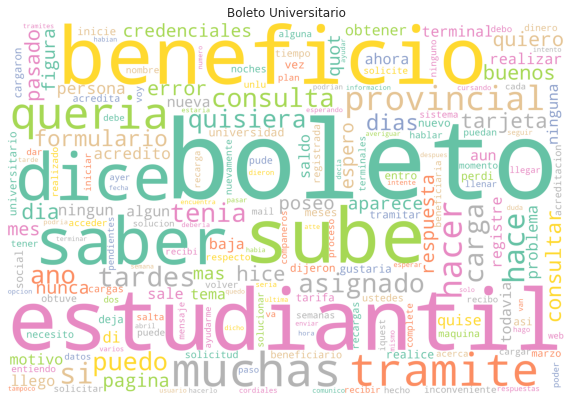


Clase: Cambio de Carrera
5 términos más importantes:
        termino     valor
66     carrera  0.331724
60   cambiarme  0.214865
61      cambio  0.174306
175     fisica  0.162001
39         asi  0.144463


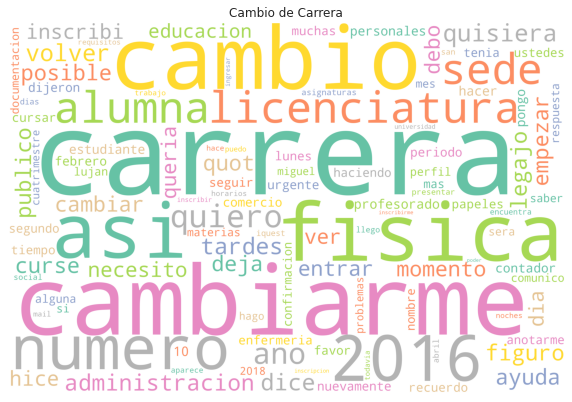


Clase: Cambio de Comisión
5 términos más importantes:
       termino     valor
76   comision  0.351689
61     cambio  0.235348
193  horarios  0.229855
356     saber  0.202916
307   posible  0.178484


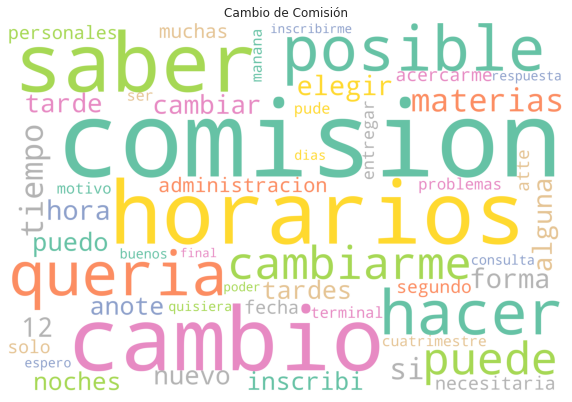


Clase: Carga de Notas
5 términos más importantes:
     termino     valor
264    nota  0.504635
173   final  0.314957
38   aprobe  0.204323
349   rendi  0.177600
253  muchas  0.175461


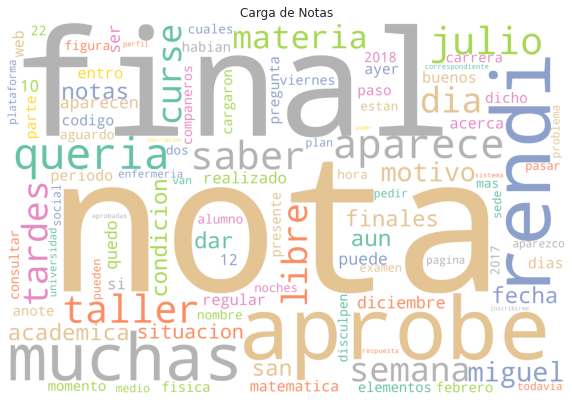


Clase: Certificados Web
5 términos más importantes:
         termino     valor
25       alumno  0.412834
84   constancia  0.328515
253      muchas  0.327058
327      queria  0.325208
346     regular  0.272761


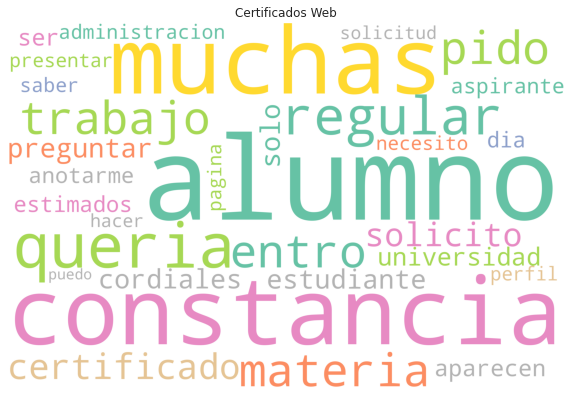


Clase: Consulta por Equivalencias
5 términos más importantes:
            termino     valor
149  equivalencias  0.515960
253         muchas  0.387077
380      solicitud  0.238358
356          saber  0.234452
370             si  0.228266


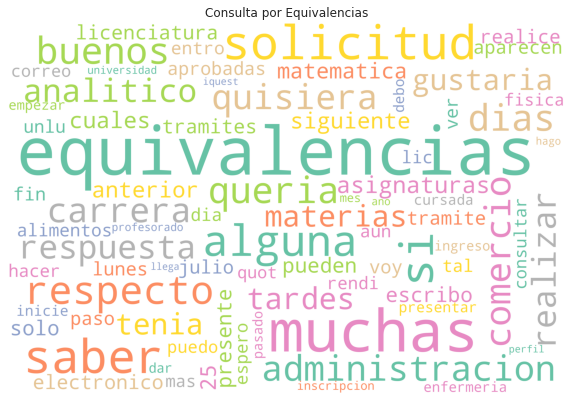


Clase: Consulta por Legajo
5 términos más importantes:
          termino     valor
218       legajo  0.602775
269       numero  0.500370
253       muchas  0.229659
392       tardes  0.222065
256  necesitaria  0.146263


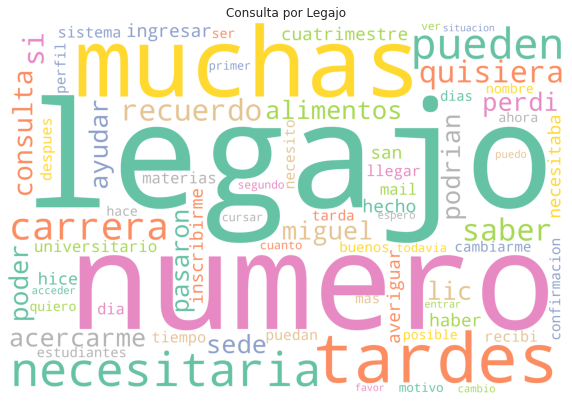


Clase: Consulta sobre Título Universitario
5 términos más importantes:
        termino     valor
403     titulo  0.538940
380  solicitud  0.243855
407    tramite  0.221204
253     muchas  0.211131
331       quot  0.188197


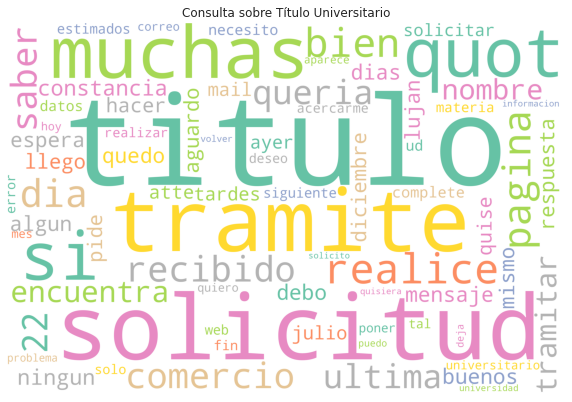


Clase: Cursadas
5 términos más importantes:
       termino     valor
356     saber  0.218694
193  horarios  0.214306
387    taller  0.214119
253    muchas  0.182279
392    tardes  0.140792


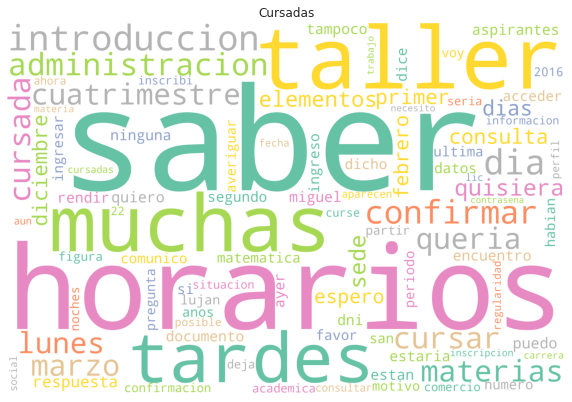


Clase: Datos Personales
5 términos más importantes:
     termino     valor
249   mismo  0.248693
91   correo  0.234813
73      com  0.200262
262  nombre  0.200029
392  tardes  0.186418


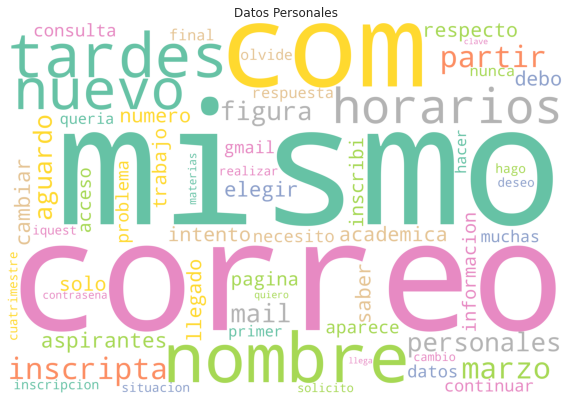


Clase: Exámenes
5 términos más importantes:
       termino     valor
173     final  0.395472
162    examen  0.245649
350    rendir  0.243326
356     saber  0.226318
163  examenes  0.225456


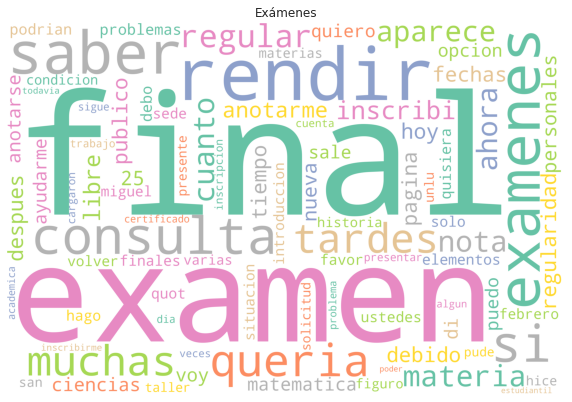


Clase: Ingreso a la Universidad
5 términos más importantes:
       termino     valor
234      mail  0.225706
253    muchas  0.108438
224     llega  0.103811
91     correo  0.101496
198  ingresar  0.076709


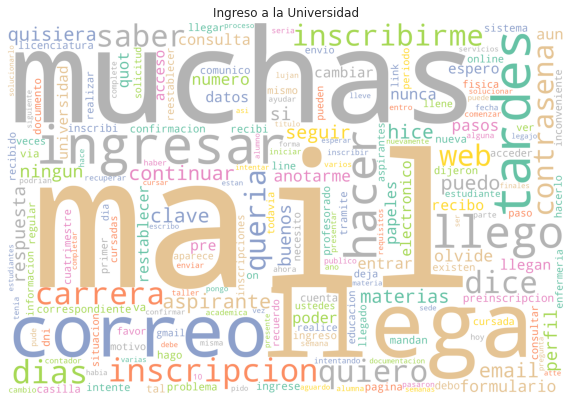


Clase: Inscripción a Cursadas
5 términos más importantes:
       termino     valor
242  materias  0.233119
253    muchas  0.152259
30   anotarme  0.147204
327    queria  0.127249
120      dias  0.119148


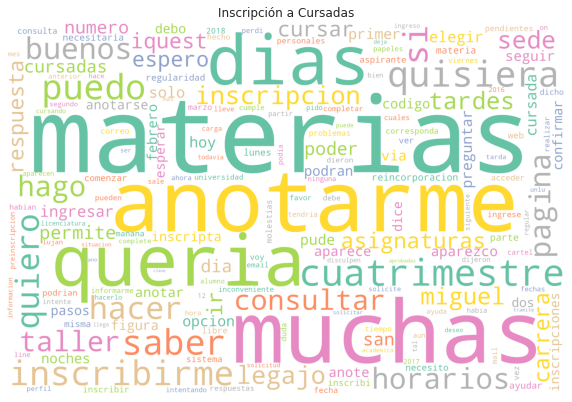


Clase: Pedido de Certificados
5 términos más importantes:
          termino     valor
242     materias  0.359203
305   porcentaje  0.324244
69   certificado  0.324239
37     aprobadas  0.294212
257     necesito  0.179443


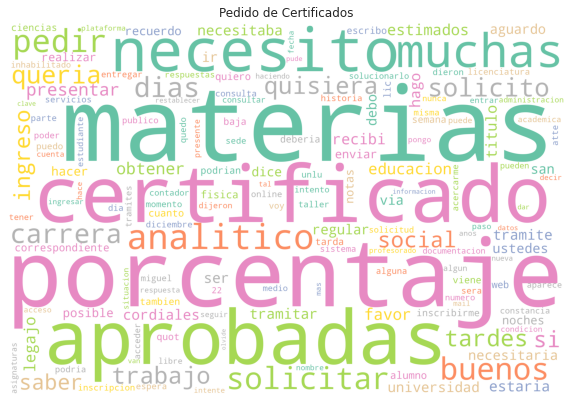


Clase: Problemas con la Clave
5 términos más importantes:
         termino     valor
71        clave  0.245037
198    ingresar  0.148863
325       puedo  0.132473
89   contrasena  0.110275
273      olvide  0.104982


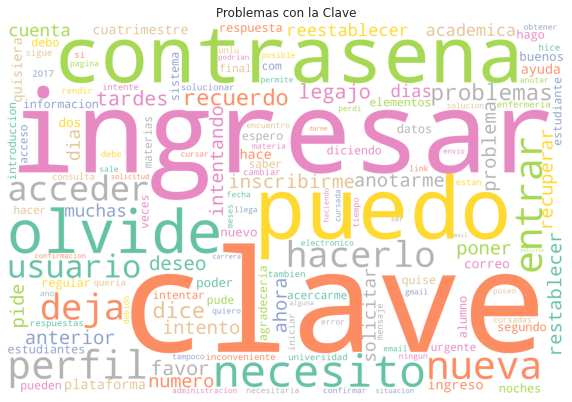


Clase: Reincorporación
5 términos más importantes:
          termino     valor
66       carrera  0.147811
219        libre  0.136795
242     materias  0.136107
81     condicion  0.121816
206  inscribirme  0.117614


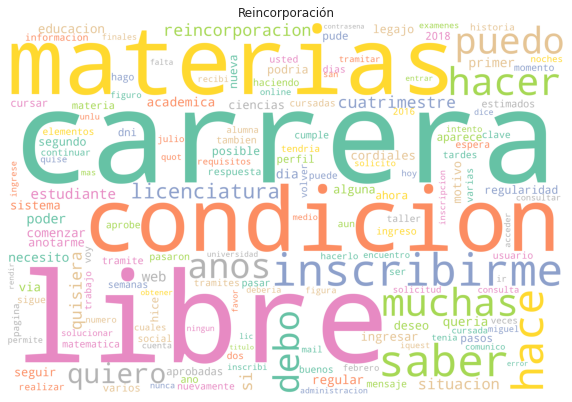


Clase: Requisitos de Ingreso
5 términos más importantes:
         termino     valor
351  requisitos  0.250013
121        dice  0.148906
198    ingresar  0.148400
99       cumple  0.144316
325       puedo  0.133710


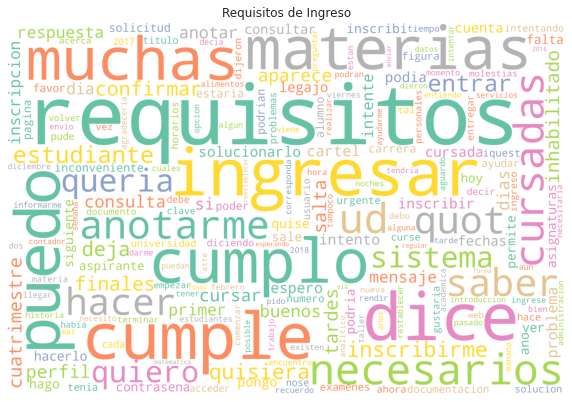


Clase: Simultaneidad de Carreras
5 términos más importantes:
             termino     valor
373   simultaneidad  0.568454
218          legajo  0.283543
282           pasar  0.244908
17   administracion  0.230818
87         contador  0.210270


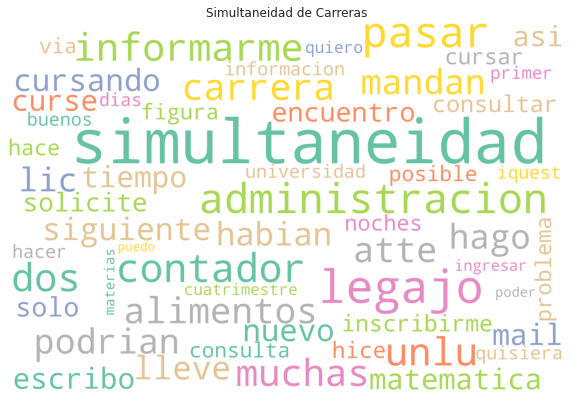


Clase: Situación Académica
5 términos más importantes:
        termino     valor
9    academica  0.281046
353  respuesta  0.224241
330   quisiera  0.215419
356      saber  0.214866
241    materia  0.184718


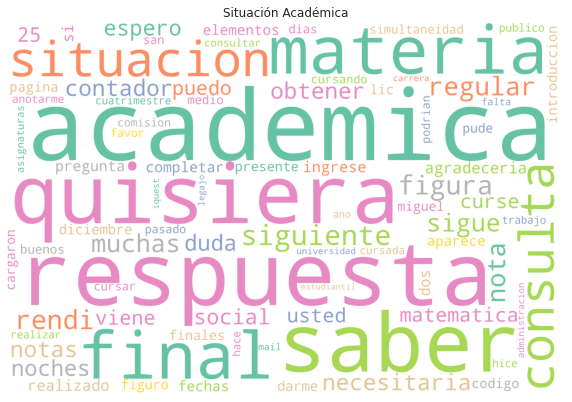


Clase: Vacunas Enfermería
5 términos más importantes:
      termino     valor
429      voy  0.193997
253   muchas  0.190435
278  papeles  0.180174
364   semana  0.173921
368    seria  0.146757


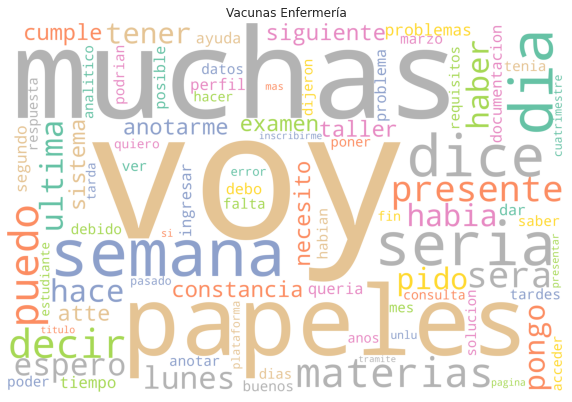

In [ ]:
N = 5

# Inicializo el diccionario donde voy a guardar las palabras importantes por clase
clases_words_labeling = {}

for clase_iter in clases:
  # Defino la clase a tratar
  print('\nClase: {}'.format(clase_iter))

  # Transpongo la fila en columna
  terminos_clase = df_terminos[df_terminos['clase']==clase_iter].transpose().reset_index()

  # Renombro las columnas
  terminos_clase.columns = ['termino', 'valor']

  # Elimino el valor de la clase
  terminos_clase = terminos_clase.loc[terminos_clase['termino']!='clase']

  # Paso a numérica la columna
  terminos_clase['valor'] = pd.to_numeric(terminos_clase['valor'])

  # Muestro los N más importantes para la clase
  print('{} términos más importantes:\n {}'.format(N, terminos_clase.nlargest(N,'valor')))

  # Agrego la lista de términos al diccionario
  clases_words_labeling[clase_iter] = list(terminos_clase.nlargest(N,'valor')['termino'])

  # Se preparan los datos para el WordCloud
  df_dis0 = terminos_clase.loc[terminos_clase['valor']>0]
  disctint0 = pd.Series(df_dis0.valor.values,index=df_dis0.termino).to_dict()

  # Genera la wordcloud
  wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='white', colormap='Set2', collocations=False).generate_from_frequencies(disctint0)
  plot_cloud(wordcloud, clase_iter)

In [ ]:
# Palabras clave por clase
clases_words_labeling

{'Boleto Universitario': ['boleto',
  'estudiantil',
  'beneficio',
  'sube',
  'saber'],
 'Cambio de Carrera': ['carrera', 'cambiarme', 'cambio', 'fisica', 'asi'],
 'Cambio de Comisión': ['comision', 'cambio', 'horarios', 'saber', 'posible'],
 'Carga de Notas': ['nota', 'final', 'aprobe', 'rendi', 'muchas'],
 'Certificados Web': ['alumno', 'constancia', 'muchas', 'queria', 'regular'],
 'Consulta por Equivalencias': ['equivalencias',
  'muchas',
  'solicitud',
  'saber',
  'si'],
 'Consulta por Legajo': ['legajo',
  'numero',
  'muchas',
  'tardes',
  'necesitaria'],
 'Consulta sobre Título Universitario': ['titulo',
  'solicitud',
  'tramite',
  'muchas',
  'quot'],
 'Cursadas': ['saber', 'horarios', 'taller', 'muchas', 'tardes'],
 'Datos Personales': ['mismo', 'correo', 'com', 'nombre', 'tardes'],
 'Exámenes': ['final', 'examen', 'rendir', 'saber', 'examenes'],
 'Ingreso a la Universidad': ['mail', 'muchas', 'llega', 'correo', 'ingresar'],
 'Inscripción a Cursadas': ['materias',
  'm

### 4.3 Prueba de Chi-cuadrado

Se realiza un Test de Chi-cuadrado para verificar dependencia entre features y clases. 
Se indagará en alguna técnica de _feature selection_ similar pero que permita verificar qué features son dependientes de qué clases.

In [ ]:
def topK_chi2(X, y, clase, N):
  '''
  Calcula la importancia de cada variable para la clase
  '''
  return 0

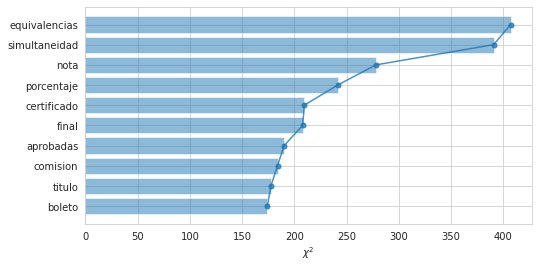

In [ ]:
# Analizo cuales son las features mas importantes según chi2
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
%matplotlib inline

# Inicializo el tamaño del gráfico
plt.figure(figsize=(8,4))

# chi2[0]: devuelve el score por cada feature
# chi2[1]: devuelve el p-value por score
chi2score = chi2(X_train, y_train)[0]

# Los paso a clave valor (feature, score_chi2)
scores = list(zip(X_train.columns, chi2score))

# Ordeno los scores (de menor a mayor)
chi2 = sorted(scores, key=lambda x:x[1])

# Me quedo con los últimos N (los mas grandes)
N=10
topchi2 = list(zip(*chi2[-N:]))

# Convierto en intervalo el total para la cantidad de barras del gráfico
x_chi = range(len(topchi2[1]))

# Tomo los labels
labels = topchi2[0]

# Grafico en función de los scores
plt.barh(x_chi, topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x_chi, '-o', markersize=5, alpha=0.8)
plt.yticks(x_chi, labels)

# Pongo el xlabel
plt.xlabel(r'$\chi^2$')

# Muestro el gráfico
plt.show();

# Referencias:
1. [Presentación](0) de apoyo al [Proyecto de Investigación](1) "Clasificación automática de correos electrónicos".

2. Clasificacion de textos por etiquetado de palabras: [short paper](2).

3. [API](3) del diccionario Collins.

4. [Funciones](4) de la [API](3) del diccionario Collins.

5. Librería [clusteval](5) para la evaluación KMeans.

[0]:https://docs.google.com/presentation/d/1-gdZ3dUI2pAfXM6Bgau53U7G4g2Bkv6DlxGESnu7A20/edit?usp=sharing 
[1]:https://github.com/jumafernandez/clasificacion_correos 
[2]:https://www.aaai.org/Papers/AAAI/2004/AAAI04-068.pdf
[3]:https://pypi.org/project/collins-client/
[4]:https://api.collinsdictionary.com/api/v1/documentation/html
[5]:https://clusteval.sdu.dk/1/mains

# Papers:
1. Ali, R. S. H., & El Gayar, N. (2019, December). Sentiment Analysis using Unlabeled Email data. In 2019 International Conference on Computational Intelligence and Knowledge Economy (ICCIKE) (pp. 328-333). IEEE.
1. Gupta, I., & Joshi, N. (2020). Real-time twitter corpus labelling using automatic clustering approach. International Journal of Computing and Digital Systems, 9, 1-9.
1. Liu, B., Li, X., Lee, W. S., & Yu, P. S. (2004, July). Text classification by labeling words. In AAAI (Vol. 4, pp. 425-430).
1. Liu, S., & Lee, I. (2018). Email sentiment analysis through k-means labeling and support vector machine classification. Cybernetics and Systems, 49(3), 181-199.
